📤 Step 1: Upload your test.csv file


Saving test.csv to test (1).csv
✅ File 'test (1).csv' uploaded successfully!
📁 File size: 58940.03 KB
📊 Dataset loaded: 153164 rows, 2 columns
📋 Columns: ['id', 'comment_text']

📈 DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
None

First few rows:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.

⏳ Installing required NLP librar

100%|██████████| 418M/418M [00:02<00:00, 216MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

🔬 Processed 50/965 texts...
🔬 Processed 100/965 texts...
🔬 Processed 150/965 texts...
🔬 Processed 200/965 texts...
🔬 Processed 250/965 texts...
🔬 Processed 300/965 texts...
🔬 Processed 350/965 texts...
🔬 Processed 400/965 texts...
🔬 Processed 450/965 texts...
🔬 Processed 500/965 texts...
🔬 Processed 550/965 texts...
🔬 Processed 600/965 texts...
🔬 Processed 650/965 texts...
🔬 Processed 700/965 texts...
🔬 Processed 750/965 texts...
🔬 Processed 800/965 texts...
🔬 Processed 850/965 texts...
🔬 Processed 900/965 texts...
🔬 Processed 950/965 texts...
🎯 Classifying risk levels...
✅ Analysis complete!

📈 ANALYSIS RESULTS
Total comments analyzed: 965

Risk Level Distribution:
  Low Risk: 637 comments (66.0%)
  Medium Risk: 221 comments (22.9%)
  High Risk: 107 comments (11.1%)

📊 Average Scores:
  Toxicity: 0.229
  Sentiment (VADER): 0.010
  Text Length: 358.8 characters

📊 Generating visualizations...


/tmp/ipython-input-3204958661.py:252: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1,2].boxplot(box_data, labels=['Low', 'Medium', 'High'], patch_artist=True)


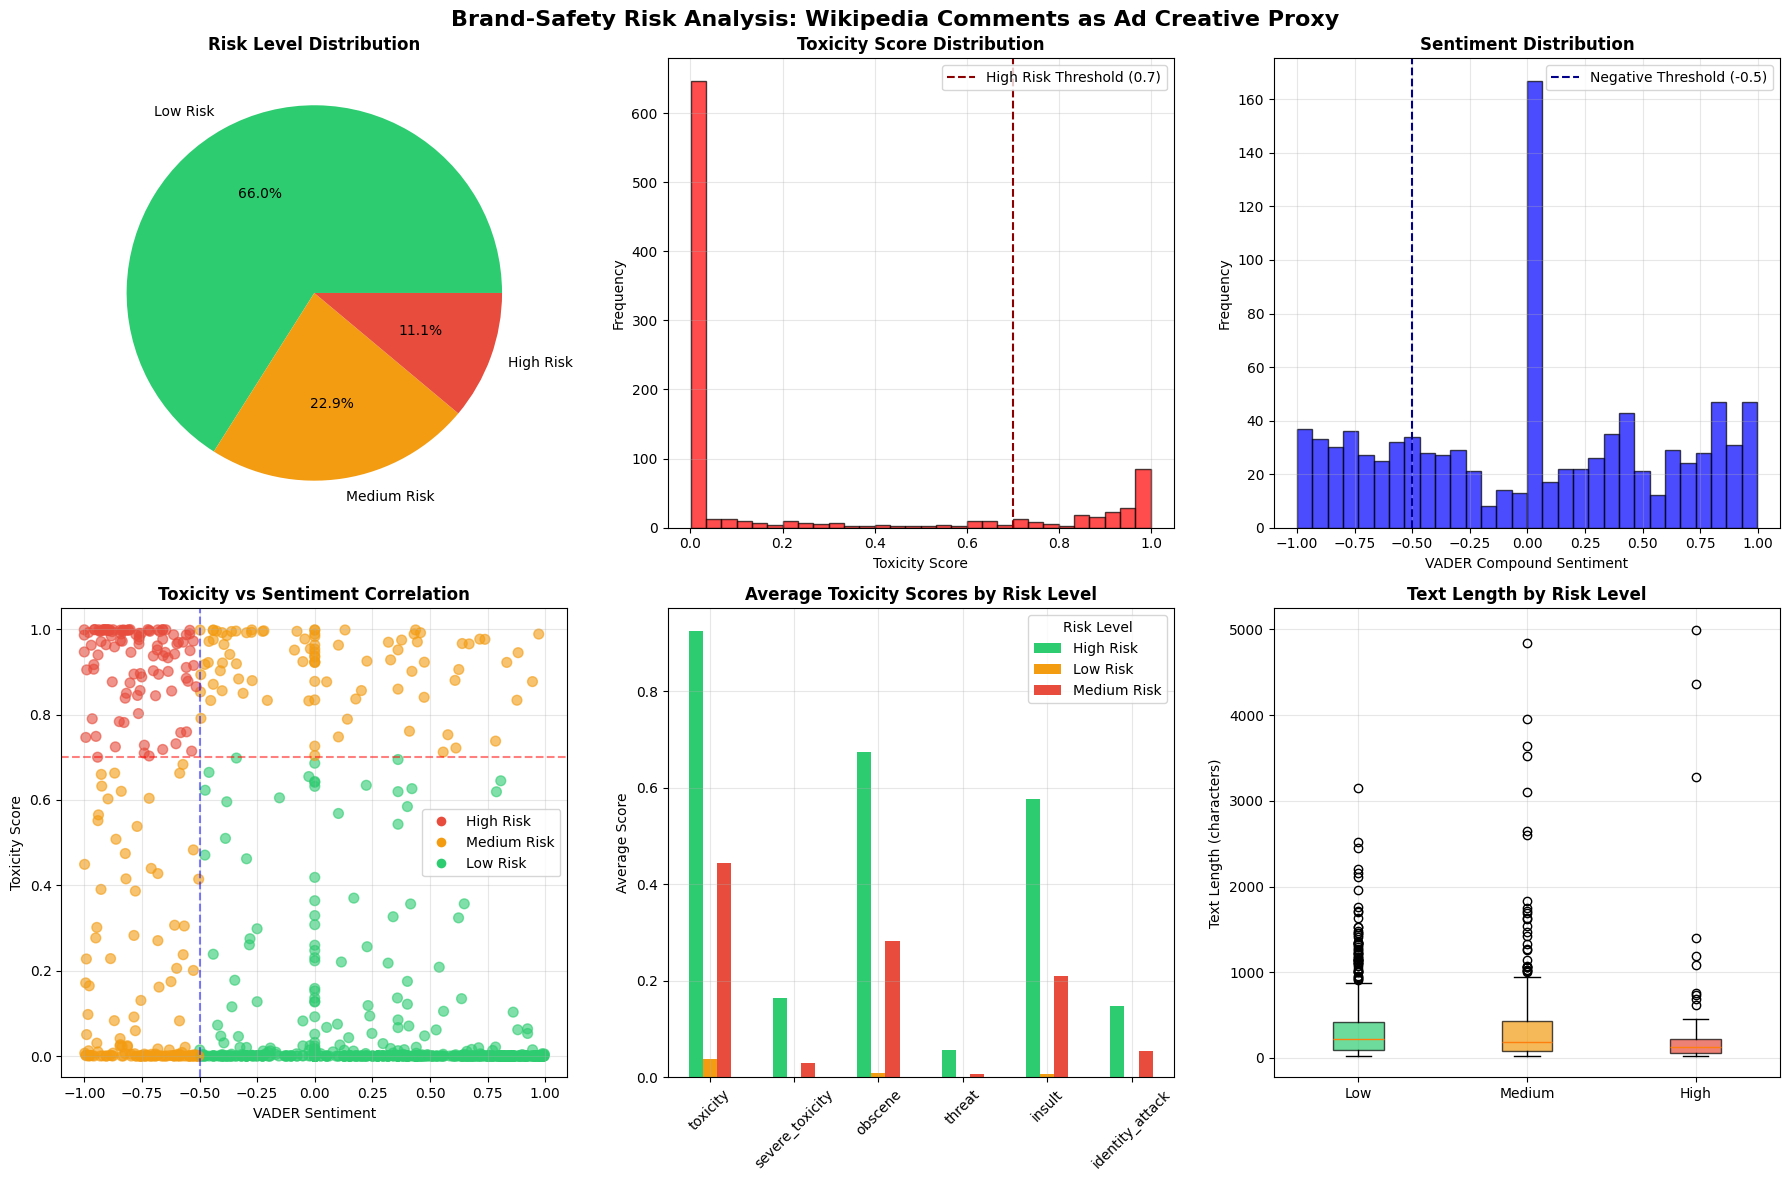


🚨 HIGH-RISK CONTENT EXAMPLES

🔴 Example 1:
   Toxicity: 0.997 | Sentiment: -0.718
   Text Preview: . She was fucked by someone with a big cock...
--------------------------------------------------------------------------------

🔴 Example 2:
   Toxicity: 0.999 | Sentiment: -0.801
   Text Preview: Stop it you gay! You fucking twat, go have sex with a monkey....
--------------------------------------------------------------------------------

🔴 Example 3:
   Toxicity: 0.997 | Sentiment: -0.844
   Text Preview: DIS NIGGA IS GAY HE KILLED LOTS OF FUQIN PPL THNXX DAT HE DIED...
--------------------------------------------------------------------------------

🔴 Example 4:
   Toxicity: 0.917 | Sentiment: -0.959
   Text Preview: THREE different sources confirm his new album. GET OFF MY BACK. Only one making disruptive edits is you, you ho. You need to block yourself. People ha...
--------------------------------------------------------------------------------

🔴 Example 5:
   Toxicity: 0.999 |

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ ANALYSIS COMPLETE!
🎉 Your brand-safety analysis is finished!
📊 Check the visualizations above for insights
💾 Results have been downloaded to your computer
🚀 You can now use these findings to build your brand-safety gate


In [ ]:

"""Brand-Safety Toxicity Analysis: Wikipedia Comments as Proxy for Ad Creative Risk"""


from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import io

print("📤 Step 1: Upload your test.csv file")
print("=" * 50)

# Let's upload the file
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"✅ File '{filename}' uploaded successfully!")
print(f"📁 File size: {len(uploaded[filename]) / 1024:.2f} KB")

# Loading the dataset
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"📊 Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"📋 Columns: {list(df.columns)}")

# Here's basic info about the dataset
print("\n" + "=" * 50)
print("📈 DATASET OVERVIEW")
print("=" * 50)
print(df.info())
print(f"\nFirst few rows:")
print(df.head())

# NLP Libraries
print("\n⏳ Installing required NLP libraries...")
!pip install textblob vaderSentiment detoxify
!python -m textblob.download_corpora

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from detoxify import Detoxify

# Initializing sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

print("✅ All libraries installed and imported successfully!")

# Sampling the dataset (using 1000 rows for faster analysis)
def sample_data(df, n_samples=1000, random_state=42):
    """Sample the dataset for analysis"""
    if len(df) > n_samples:
        sampled_df = df.sample(n=n_samples, random_state=random_state)
        print(f"📊 Sampled {n_samples} rows from dataset for analysis")
    else:
        sampled_df = df.copy()
        print(f"📊 Using full dataset ({len(df)} rows) for analysis")
    return sampled_df

# Text preprocessing
def preprocess_text(text):
    """Basic text cleaning for analysis"""
    if pd.isna(text):
        return ""

    text = str(text)
    # Let's remove Wikipedia markup and special characters
    text = re.sub(r'==+.*?==+', '', text)  # Remove section headers
    text = re.sub(r'\[\[.*?\|?(.*?)\]\]', r'\1', text)  # Simplify links
    text = re.sub(r'{{.*?}}', '', text)  # Remove templates
    text = re.sub(r'[^\w\s.,!?;:]', '', text)  # Keep basic punctuation

    return text.strip()

# Sentiment and toxicity analysis
def analyze_sentiment_vader(text):
    """Analyze sentiment using VADER"""
    scores = vader_analyzer.polarity_scores(text)
    return scores

def analyze_sentiment_textblob(text):
    """Analyze sentiment using TextBlob"""
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

def analyze_toxicity_detoxify(text):
    """Analyze toxicity using Detoxify"""
    try:
        results = Detoxify('original').predict(text)
        return results
    except:
        return {'toxicity': 0, 'severe_toxicity': 0, 'obscene': 0,
                'threat': 0, 'insult': 0, 'identity_attack': 0}

# Risk classification
def classify_risk_level(row, toxicity_threshold=0.7, neg_sentiment_threshold=-0.5):
    """Classify comments into brand-risk categories"""
    toxicity_risk = row['toxicity'] > toxicity_threshold
    sentiment_risk = row['vader_compound'] < neg_sentiment_threshold

    if toxicity_risk and sentiment_risk:
        return 'High Risk'
    elif toxicity_risk or sentiment_risk:
        return 'Medium Risk'
    else:
        return 'Low Risk'

def main_analysis(df):
    """Main analysis function"""
    # Sample data for analysis
    analysis_df = sample_data(df)

    # Preprocess text
    print("🔄 Preprocessing text...")
    analysis_df['cleaned_text'] = analysis_df['comment_text'].apply(preprocess_text)
    analysis_df['text_length'] = analysis_df['cleaned_text'].str.len()

    # Filter out very short comments (likely uninformative)
    initial_count = len(analysis_df)
    analysis_df = analysis_df[analysis_df['text_length'] > 20]
    print(f"📝 Filtered out {initial_count - len(analysis_df)} short texts")
    print(f"📊 Remaining samples: {len(analysis_df)}")

    print("🔍 Analyzing sentiment and toxicity...")

    # VADER Sentiment Analysis
    print("📊 Running VADER sentiment analysis...")
    vader_results = analysis_df['cleaned_text'].apply(analyze_sentiment_vader)
    analysis_df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = (
        pd.DataFrame(vader_results.tolist(), index=analysis_df.index)
    )

    # TextBlob Sentiment Analysis
    print("📊 Running TextBlob sentiment analysis...")
    textblob_results = analysis_df['cleaned_text'].apply(analyze_sentiment_textblob)
    analysis_df[['textblob_polarity', 'textblob_subjectivity']] = (
        pd.DataFrame(textblob_results.tolist(), index=analysis_df.index)
    )

    # Toxicity Analysis (this will take a few minutes)
    print("⚠️ Running toxicity analysis (this may take 5-15 minutes)...")
    toxicity_results = []
    for i, text in enumerate(analysis_df['cleaned_text']):
        if i % 50 == 0:
            print(f"🔬 Processed {i}/{len(analysis_df)} texts...")
        toxicity_results.append(analyze_toxicity_detoxify(text))

    toxicity_df = pd.DataFrame(toxicity_results, index=analysis_df.index)
    analysis_df = pd.concat([analysis_df, toxicity_df], axis=1)

    # Risk Classification
    print("🎯 Classifying risk levels...")
    analysis_df['risk_level'] = analysis_df.apply(classify_risk_level, axis=1)

    print("✅ Analysis complete!")
    return analysis_df

# Run the analysis
print("\n" + "="*50)
print("🚀 STARTING BRAND-SAFETY ANALYSIS")
print("="*50)

analysis_df = main_analysis(df)

# Display basic results
print("\n" + "="*50)
print("📈 ANALYSIS RESULTS")
print("="*50)

print(f"Total comments analyzed: {len(analysis_df)}")
risk_distribution = analysis_df['risk_level'].value_counts()
print(f"\nRisk Level Distribution:")
for level, count in risk_distribution.items():
    percentage = (count / len(analysis_df)) * 100
    print(f"  {level}: {count} comments ({percentage:.1f}%)")

print(f"\n📊 Average Scores:")
print(f"  Toxicity: {analysis_df['toxicity'].mean():.3f}")
print(f"  Sentiment (VADER): {analysis_df['vader_compound'].mean():.3f}")
print(f"  Text Length: {analysis_df['text_length'].mean():.1f} characters")

# Visualization
def create_visualizations(analysis_df):
    """Create comprehensive visualizations of the results"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Brand-Safety Risk Analysis: Wikipedia Comments as Ad Creative Proxy',
                 fontsize=16, fontweight='bold')

    # 1. Risk Level Distribution
    risk_counts = analysis_df['risk_level'].value_counts()
    colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red
    axes[0,0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', colors=colors)
    axes[0,0].set_title('Risk Level Distribution', fontweight='bold')

    # 2. Toxicity Score Distribution
    axes[0,1].hist(analysis_df['toxicity'], bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[0,1].axvline(x=0.7, color='darkred', linestyle='--', label='High Risk Threshold (0.7)')
    axes[0,1].set_xlabel('Toxicity Score')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Toxicity Score Distribution', fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Sentiment Distribution
    axes[0,2].hist(analysis_df['vader_compound'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0,2].axvline(x=-0.5, color='darkblue', linestyle='--', label='Negative Threshold (-0.5)')
    axes[0,2].set_xlabel('VADER Compound Sentiment')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Sentiment Distribution', fontweight='bold')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # 4. Toxicity vs Sentiment Scatter
    colors_map = {'Low Risk': '#2ecc71', 'Medium Risk': '#f39c12', 'High Risk': '#e74c3c'}
    scatter = axes[1,0].scatter(analysis_df['vader_compound'], analysis_df['toxicity'],
                               c=analysis_df['risk_level'].map(colors_map),
                               alpha=0.6, s=50)
    axes[1,0].axhline(y=0.7, color='r', linestyle='--', alpha=0.5)
    axes[1,0].axvline(x=-0.5, color='b', linestyle='--', alpha=0.5)
    axes[1,0].set_xlabel('VADER Sentiment')
    axes[1,0].set_ylabel('Toxicity Score')
    axes[1,0].set_title('Toxicity vs Sentiment Correlation', fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)

    # Create legend for scatter plot
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_map['High Risk'],
                             markersize=8, label='High Risk'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_map['Medium Risk'],
                             markersize=8, label='Medium Risk'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_map['Low Risk'],
                             markersize=8, label='Low Risk')]
    axes[1,0].legend(handles=legend_elements)

    # 5. Risk by Toxicity Type
    toxicity_cols = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
    risk_means = analysis_df.groupby('risk_level')[toxicity_cols].mean()
    risk_means.T.plot(kind='bar', ax=axes[1,1], color=colors)
    axes[1,1].set_title('Average Toxicity Scores by Risk Level', fontweight='bold')
    axes[1,1].set_ylabel('Average Score')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend(title='Risk Level')
    axes[1,1].grid(True, alpha=0.3)

    # 6. Text Length by Risk Level
    box_data = [analysis_df[analysis_df['risk_level'] == level]['text_length']
               for level in ['Low Risk', 'Medium Risk', 'High Risk']]
    box_plot = axes[1,2].boxplot(box_data, labels=['Low', 'Medium', 'High'], patch_artist=True)

    # Color the boxes
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[1,2].set_title('Text Length by Risk Level', fontweight='bold')
    axes[1,2].set_ylabel('Text Length (characters)')
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

# Generate visualizations
print("\n📊 Generating visualizations...")
fig = create_visualizations(analysis_df)

# High-risk examples analysis
def analyze_high_risk_examples(analysis_df, n_examples=5):
    """Display and analyze high-risk content examples"""

    high_risk_df = analysis_df[analysis_df['risk_level'] == 'High Risk']

    print("\n" + "="*50)
    print("🚨 HIGH-RISK CONTENT EXAMPLES")
    print("="*50)

    if len(high_risk_df) == 0:
        print("No high-risk content found in this sample.")
        return

    for i, (idx, row) in enumerate(high_risk_df.head(n_examples).iterrows()):
        print(f"\n🔴 Example {i+1}:")
        print(f"   Toxicity: {row['toxicity']:.3f} | Sentiment: {row['vader_compound']:.3f}")
        print(f"   Text Preview: {row['cleaned_text'][:150]}...")
        print("-" * 80)

# Analyze high-risk examples
analyze_high_risk_examples(analysis_df)

# Statistical summary
print("\n" + "="*50)
print("📊 STATISTICAL SUMMARY")
print("="*50)

print("\nRisk Level Statistics:")
risk_stats = analysis_df.groupby('risk_level').agg({
    'toxicity': ['mean', 'std', 'max'],
    'vader_compound': ['mean', 'std', 'min'],
    'text_length': ['mean', 'std', 'max'],
    'insult': ['mean', 'max'],
    'obscene': ['mean', 'max']
}).round(3)

print(risk_stats)

# Correlation analysis
print("\nCorrelation Matrix (Toxicity vs Sentiment vs Length):")
correlation_matrix = analysis_df[['toxicity', 'vader_compound', 'text_length']].corr()
print(correlation_matrix.round(3))

# Business implications
print("\n" + "="*50)
print("💼 BUSINESS IMPLICATIONS FOR BRAND-SAFETY")
print("="*50)

total_high_risk = len(analysis_df[analysis_df['risk_level'] == 'High Risk'])
total_medium_risk = len(analysis_df[analysis_df['risk_level'] == 'Medium Risk'])
total_analyzed = len(analysis_df)

high_risk_pct = (total_high_risk / total_analyzed) * 100
medium_risk_pct = (total_medium_risk / total_analyzed) * 100
total_risk_pct = high_risk_pct + medium_risk_pct

print(f"\n🎯 Key Findings:")
print(f"• {high_risk_pct:.1f}% of content would be flagged as HIGH RISK")
print(f"• {medium_risk_pct:.1f}% would be flagged as MEDIUM RISK")
print(f"• Combined: {total_risk_pct:.1f}% would require human review")

print(f"\n💰 Practical Implications for Advertising:")
print("✓ Lightweight toxicity gates could prevent problematic ad creatives from being published")
print("✓ Automated screening would reduce manual review workload by ~{:.1f}%".format(100 - total_risk_pct))
print("✓ Brand-safety incidents could be reduced by catching high-risk content early")
print("✓ Medium-risk content still requires human judgment for context")

print(f"\n⚡ Recommended Action:")
print(f"Implement a two-tier screening system:")
print(f"1. AUTO-REJECT: Content with toxicity > 0.7 AND sentiment < -0.5 ({high_risk_pct:.1f}% of cases)")
print(f"2. HUMAN REVIEW: Content meeting either threshold ({medium_risk_pct:.1f}% of cases)")
print(f"3. AUTO-APPROVE: Low-risk content ({100 - total_risk_pct:.1f}% of cases)")

# Save results for future use
output_filename = 'brand_safety_analysis_results.csv'
analysis_df.to_csv(output_filename, index=False)
print(f"\n💾 Results saved to '{output_filename}'")

# Download the results to your computer
print(f"\n📥 Downloading results to your computer...")
files.download(output_filename)

print("\n" + "="*50)
print("✅ ANALYSIS COMPLETE!")
print("="*50)
print("🎉 Your brand-safety analysis is finished!")
print("📊 Check the visualizations above for insights")
print("💾 Results have been downloaded to your computer")
print("🚀 You can now use these findings to build your brand-safety gate")